# Import necessary libraries
SAFEP_parse.py contains all the functions and library calls necessary to run the notebook
# Required libraries:
- numpy
- pandas
- matplotlib
- alchemlyb (pip install git+https://github.com/alchemistry/alchemlyb)
- natsort (for sorting file names)
- glob (for unix-like file paths)



# IMPORTANT: Make sure the temperature (set below) matches the temperature you used to run the simulations.

In [1]:
from AFEP_parse import *
plt.rcParams['figure.dpi'] = 150

In [2]:
import os

In [3]:
path='/Users/ezry/Downloads/POGE_2/'
#path='/u2/home_u2/ems363/Documents/ELIC_DCDs_Analyses/PCPG31/POGE_2/'
#path='/path/to/output/files'
filename='PO*.fepout'
fepoutFiles = glob(path+filename)
temperature = 303.15
RT = 0.00198720650096 * temperature # ca. 0.59kcal/mol
totalSize = 0
for file in fepoutFiles:
    totalSize += os.path.getsize(file)
print(f"Will process {len(fepoutFiles)} fepout files.\nTotal size:{np.round(totalSize/10**9, 2)}GB")

Will process 48 fepout files.
Total size:0.04GB


In [4]:
fepoutFiles = natsorted(fepoutFiles)
maxSize = 10**9 #Don't use the alchemlyb parser if larger than this size. (bytes)
decorrelate = True #Flag for decorrelation of samples
detectEQ = False #Flag for automated equilibrium detection
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

# Read Data
See Shirts and Chodera (2008) for more details

"Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

In [5]:
if totalSize < maxSize:
    from alchemlyb.preprocessing import subsampling

    u_nk = namd.extract_u_nk(fepoutFiles, temperature)
    
    affix=""
    
    if decorrelate:
        print("Decorrelating samples")
        method = 'dE'
        affix = f'{affix}_decorrelated_{method}'
        groups = u_nk.groupby('fep-lambda')
        decorr = pd.DataFrame([])
        for key, group in groups:
            test = subsampling.decorrelate_u_nk(group, method)
            decorr = decorr.append(test)
        u_nk = decorr
    else:
        affix = f'{affix}_unprocessed'
    
    if detectEQ:
        print("Detecting Equilibrium")
        affix = f"{affix}_AutoEquilibrium"
        groups = u_nk.groupby('fep-lambda')
        EQ = pd.DataFrame([])
        for key, group in groups:
            group = group[~group.index.duplicated(keep='first')]
            test = subsampling.equilibrium_detection(group, group.dropna(axis=1).iloc[:,-1])
            EQ = EQ.append(test)
        u_nk = EQ
    else:
        affix=f"{affix}_HardEquilibrium"
    

else:
    print(f"Warning: The files you are trying to read are quite large. Total size={totalSize}.\nTry the read, decorrelate, save method in the Expanded version of this notebook or increase the maxSize variable above.\nIn the future, consider using less frequent sampling (e.g. every 100 steps).")

         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875
/Users/ezry/opt/anaconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time').duplicated('time').any()
/Users/ezry/opt/anaconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:133: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time', name=

Decorrelating samples


# Carry out MBAR Fitting and Analyses

In [6]:
u_nk = u_nk.sort_index(level=1)

In [7]:
bar = BAR()
bar.fit(u_nk)

BAR()

# Extract key features from the MBAR fitting and get ΔG
Note: alchemlyb operates in units of kT by default. We multiply by RT to convert to units of kcal/mol.

In [8]:
l, l_mid, f, df, ddf, errors = get_BAR(bar)
changeAndError = f'\u0394G = {np.round(f.iloc[-1]*RT, 1)}\u00B1{np.round(errors[-1], 3)} kcal/mol'
print(changeAndError)

ΔG = 21.0±0.417 kcal/mol


# Plot the change in free energy based on MBAR estimates

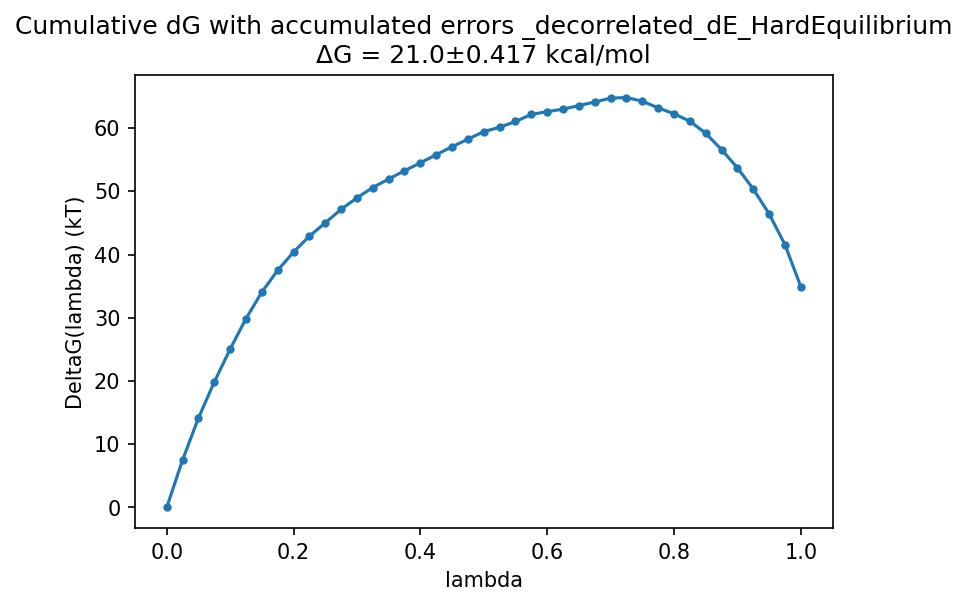

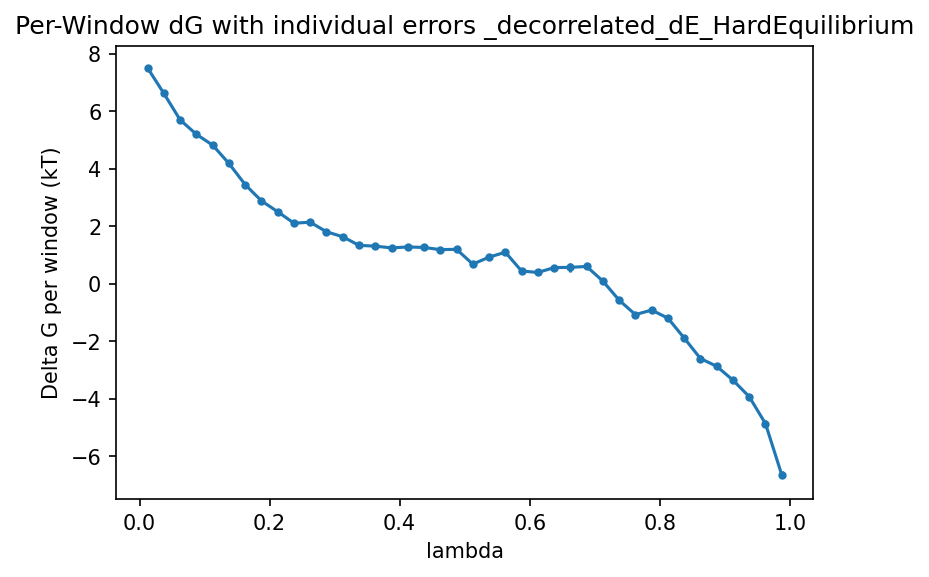

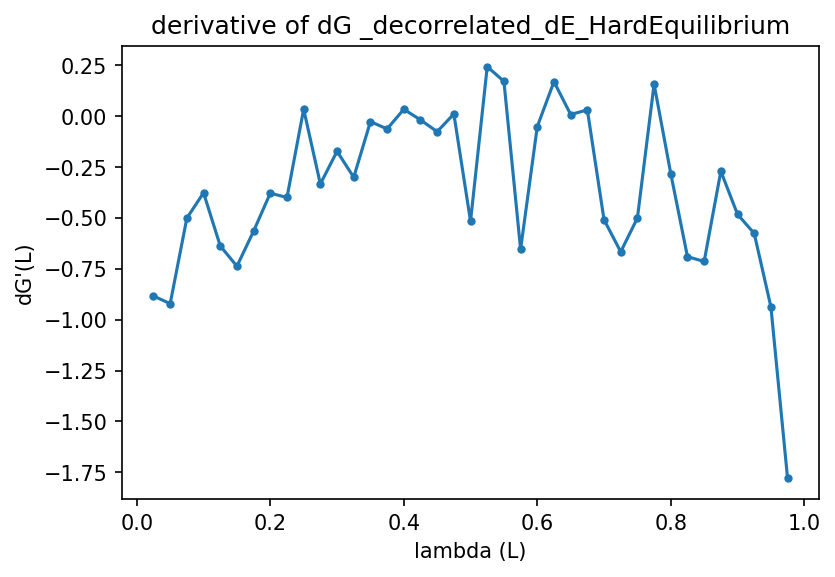

In [9]:
# Cumulative change in kT
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.title(f'Cumulative dG with accumulated errors {affix}\n{changeAndError}')
plt.savefig(f'{path}dG_cumulative_kT_{affix}.png', dpi=600)
plt.show()

# Cumulative change in kcal/mol
"""
plt.errorbar(l, f * RT, yerr=errors*RT, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda)(kcal/mol)')
plt.savefig(f'{path}dG_cumulative_kcal_per_mol_{affix}.png', dpi=600)
plt.show()
"""
# Per-window change in kT
plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.title(f'Per-Window dG with individual errors {affix}')
plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()

# Per-window change in kT

plt.errorbar(l[1:-1], np.diff(df), marker='.')
plt.xlabel('lambda (L)')
plt.ylabel("dG'(L)")
plt.title(f'derivative of dG {affix}')
plt.savefig(f'{path}dG_prime_{affix}.png', dpi=600)
plt.show()


# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

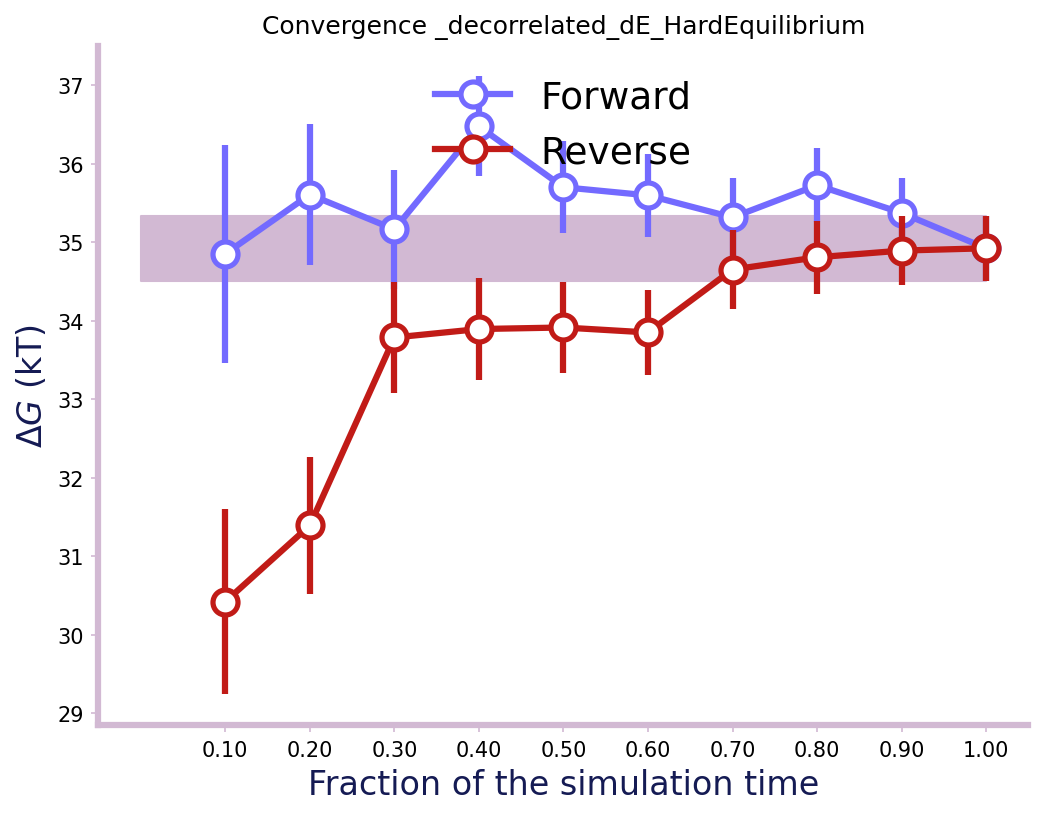

In [10]:
convergence_plot(u_nk, l)
plt.title(f'Convergence {affix}')
plt.savefig(f'{path}convergence_{affix}.png', dpi=600)

In [55]:
sampled

""


In [79]:

groups = u_nk.groupby('fep-lambda')

Gs = {}
iterations = 10

for N in [1, 10, 20, 30, 40, 50, 100, 200, 300, 500, 1000]:
    Fs = []
    Bs = []
    for i in np.arange(iterations):
        sampled = pd.DataFrame([])
        for key, group in groups:
            rows = np.random.choice(, size=N)
            test = group.iloc[rows,:]
            sampled = sampled.append(test)

        l, l_mid, dG_f, dG_b = get_EXP(pd.DataFrame(sampled))
        Fs.append(np.sum(dG_f))
        Bs.append(np.sum(-dG_b))
        
    Gs[(N, 'F')] = Fs
    Gs[(N, 'B')] = Bs
    


In [103]:
tmp = pd.DataFrame(Gs).T.copy()

In [104]:
tmp = tmp.reset_index().set_index('level_0')

In [123]:
newtmp = {}
for x in tmp.index:
    newtmp[x] = tmp.loc[x].melt().iloc[2:,1].values

<AxesSubplot:>

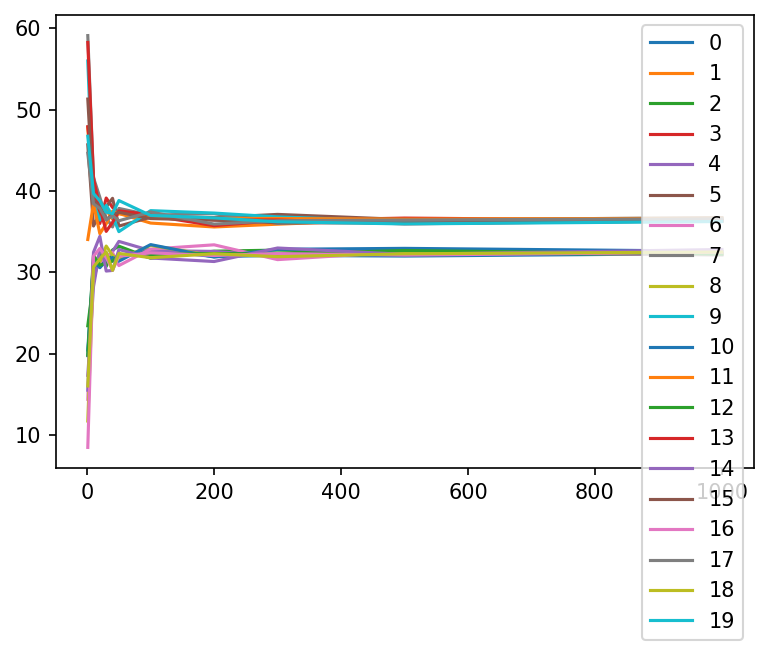

In [129]:
pd.DataFrame(newtmp).T.plot()

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

In [24]:
l, l_mid, dG_f, dG_b = get_EXP(u_nk)

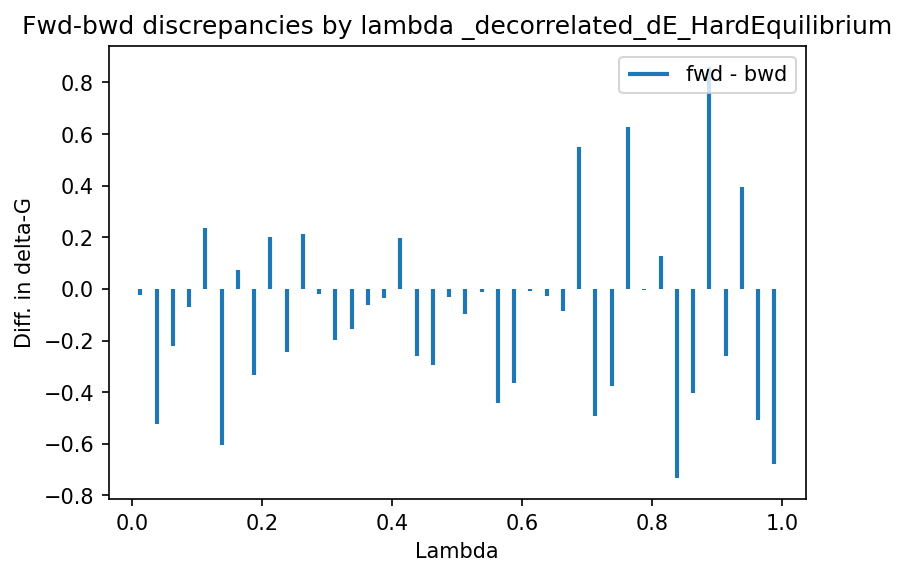

In [12]:
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=2)

plt.legend()
plt.title(f'Fwd-bwd discrepancies by lambda {affix}')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')
plt.savefig(f'{path}discrepancies_{affix}.png', dpi=600)

# Estimate and plot the Probability Density Function (PDF) for the differences shown above.

In [13]:
from scipy.special import erfc
from scipy.optimize import curve_fit as scipyFit
from scipy.stats import skew
#Wrapper for fitting the normal CDF
def cumFn(x, m, s):
    r = norm.cdf(x, m, s)
    return r

def pdfFn(x,m,s):
    r = norm.pdf(x,m,s)
    return r

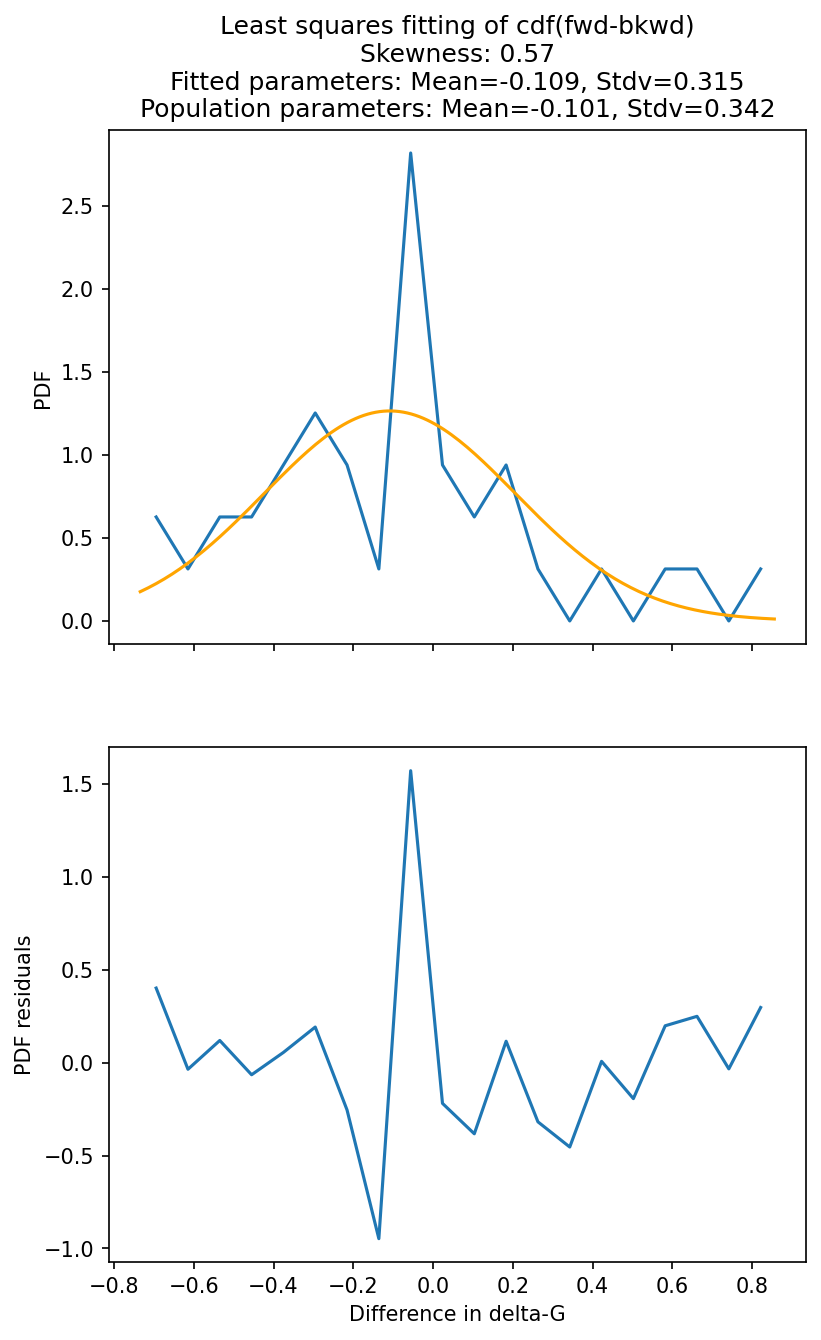

In [14]:
diff = dG_f + np.array(dG_b)
diff.sort()
X = diff
Y = np.arange(len(X))/len(X)

#plot the data
fig, (pdfAx, pdfResid) = plt.subplots(2, 1, sharex=True)
plt.xlabel('Difference in delta-G')

#fit a normal distribution to the existing data
if DiscrepancyFitting == 'LS':
    fitted = scipyFit(cumFn, X, Y)[0] #Fit norm.cdf to (X,Y)
elif DiscrepancyFitting == 'ML':
    fitted = norm.fit(X) # fit a normal distribution to X
else:
    raise("Error: Discrepancy fitting code not known. Acceptable values: ML (maximum likelihood) or LS (least squares)")
discrepancies = dG_f + np.array(dG_b)

#pdf
dx = 0.01

binNum = 20
pdfY, pdfX = np.histogram(discrepancies, bins=binNum, density=True)
pdfX = (pdfX[1:]+pdfX[:-1])/2

pdfXnorm  = np.arange(np.min(X), np.max(X), dx)
pdfYnorm = norm.pdf(pdfXnorm, fitted[0], fitted[1])

pdfYexpected = norm.pdf(pdfX, fitted[0], fitted[1])

pdfAx.plot(pdfX, pdfY,  label="Estimated Distribution")
pdfAx.set_ylabel("PDF")
pdfAx.plot(pdfXnorm, pdfYnorm, label="Fitted Normal Distribution", color="orange")

#pdf residuals
pdfResiduals = pdfY-pdfYexpected
pdfResid.plot(pdfX, pdfResiduals)
pdfResid.set_ylabel("PDF residuals") 

fig.set_figheight(10)
if DiscrepancyFitting == 'LS':
    pdfAx.title.set_text(f"Least squares fitting of cdf(fwd-bkwd)\nSkewness: {np.round(skew(X),2)}\nFitted parameters: Mean={np.round(fitted[0],3)}, Stdv={np.round(fitted[1],3)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X),3)}")
    plt.savefig(f"{path}LeastSquares_pdf_{affix}.png", dpi=600)
elif DiscrepancyFitting == 'ML':
    pdfAx.title.set_text(f"Maximum likelihood fitting of fwd-bkwd\nFitted parameters: Mean={np.round(fitted[0],3)}, Stdv={np.round(fitted[1],3)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X),3)}")
    plt.savefig(f"{path}MaximumLikelihood_pdf_{affix}.png", dpi=600)

plt.show()